# OpenPrefEval: Dead Simple Open LLM Evaluation

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# !pip install peft bitsandbytes -q
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
datasets = get_default_datasets(100)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 })]

In [4]:

# 
from peft import AutoPeftModelForCausalLM, get_peft_model, PeftConfig, PeftModelForCausalLM
import torch
from transformers import BitsAndBytesConfig
from open_pref_eval.plot.radar import radar_plot
model_name = "markab/Qwen1.5-Capybara-0.5B-Chat" # quick no diff
model_name = "Rustamshry/Qwen3-0.6B-OpenMathReason"


model_name = "wassname/qwen-7B-codefourchan-QLoRA"
# model_name = "wassname/qwen-14B-codefourchan-QLoRA"

# model_name = "alignment-handbook/zephyr-7b-sft-qlora"
# model_name = "gepardzik/LLama-3-8b-rogue-lora" # small diff

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

### Load method 1 a huggingface model with PeftMixin
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", 
    torch_dtype=torch.bfloat16, 
    quantization_config=quantization_config
)
# model.load_adapter(model_name)
# print(model.peft_config)
# model.delete_adapter('default')
# model.load_adapter(model_name)
# print(model.peft_config)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:

# # ## Load method 2 a PeftModel
# model = PeftModelForCausalLM.from_pretrained(
#     model,
#     model_name,
#     device_map="auto",
#     torch_dtype=torch.bfloat16,
#     quantization_config=quantization_config,
# )
# print(model.peft_config)

In [6]:

tokenizer = AutoTokenizer.from_pretrained(model.peft_config['default'].base_model_name_or_path)

In [7]:
# model.delete_adapter('default')
# model.load_adapter(model_name, '4chan')

In [8]:
print(model.peft_config)

{'default': LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='unsloth/Qwen2.5-Coder-7B-Instruct', revision=None, inference_mode=True, r=64, target_modules={'o_proj', 'q_proj', 'down_proj', 'v_proj', 'up_proj', 'gate_proj', 'k_proj'}, exclude_modules=None, lora_alpha=64, lora_dropout=0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)}


In [9]:
import numpy as np
from functools import partial
import numpy as np
import pandas as pd

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [10]:
from open_pref_eval.scoring import score_ipo, score_preferences, score_confidence_weighted, score_with_entropy_weight, score_seq_entropy_weighted
score_fns = {
    "preferences": score_preferences,
    # "cumsum": score_cumsum,
    # "weighted": score_weighted, # littlediff
    # "weighted_prob": score_weighted_prob, # nan
    # "with_weight": score_with_weight,
    # "f_alpha_divergance": score_f_alpha_divergance,
    # "f_divergance": score_f_divergance,
    # "min": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.min(x, dim=-1).values),
    # "max": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.max(x, dim=-1).values),
    # "mean": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.mean(x, dim=-1)),
    # "median": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.median(x, dim=-1).values),
    # "std": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.std(x, dim=-1)),
    "ipo": score_ipo,
    "seq_entropy_weighted": score_seq_entropy_weighted,
    # "certainty_weighted": score_certainty_weighted,
    # "power_mean": score_power_mean,
    # "with_decay": score_with_decay,
    # "percentile": score_percentile,
    # "1st_diverg": score_1st_diverg,
    # "perplexity_ratio": score_perplexity_ratio,
    'confidence_wighted0.5': partial(score_confidence_weighted, T=0.5),
    'confidence_weighted': score_confidence_weighted,
    'confidence_weighted5': partial(score_confidence_weighted, T=5.0),
    'confidence_weighted10': partial(score_confidence_weighted, T=10.0),
    'with_entropy_weight0.5': partial(score_with_entropy_weight, alpha=0.5),
    'with_entropy_weight': score_with_entropy_weight,
    'with_entropy_weight5': partial(score_with_entropy_weight, alpha=5.0),
    'with_entropy_weight10': partial(score_with_entropy_weight, alpha=10.0),

}


In [11]:
results, df_raw1 = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets,
    batch_size=6,
    max_length=1024,
    max_prompt_length=512,
    verbose=2,
    score_fn=score_fns
) 
# results

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2025-05-25 05:51:20.968 | DEBUG    | open_pref_eval.evaluation:eval_dataset:192 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval imdb_preferences-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-25 05:52:12.522 | DEBUG    | open_pref_eval.evaluation:eval_dataset:192 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 05:52:18.049 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 05:52:22.698 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33%

Eval truthful_qa_preferences-validation[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-25 05:53:12.463 | DEBUG    | open_pref_eval.evaluation:eval_dataset:192 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-25 05:53:23.399 | DEBUG    | open_pref_eval.evaluation:eval_dataset:192 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-25 05:53:37.200 | DEBUG    | open_pref_eval.evaluation:eval_dataset:192 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-25 05:53:47.468 | DEBUG    | open_pref_eval.evaluation:eval_dataset:192 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-25 05:54:01.214 | DEBUG    | open_pref_eval.evaluation:eval_dataset:192 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-25 05:54:12.229 | DEBUG    | open_pref_eval.evaluation:eval_dataset:192 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [12]:
model_id = 'snake7gun/tiny-random-qwen3'
model2 = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto",
    torch_dtype=torch.bfloat16, 
    quantization_config=quantization_config
)
tokenizer2 = AutoTokenizer.from_pretrained(model_id)

In [13]:
results2, df_raw2 = evaluate_model(
    model=model2,
    tokenizer=tokenizer2,
    datasets=datasets,
    batch_size=6,
    max_length=1024,
    max_prompt_length=512,
    verbose=2,
    score_fn=score_fns
) 
# results
df_raw2['adapter'] = model_id


  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval imdb_preferences-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 05:54:29.251 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 05:54:29.496 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-25 05:54:29.821 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 05:54:30.023 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [14]:
df_raw = pd.concat([df_raw1, df_raw2], axis=0)

In [15]:
df_raw.fillna({'adapter': 'base'}, inplace=True)

How to do this? So the logprobs are uncalibrated and kind of meaningless, but the ranking is good. So we just look at which is prefered. And take the mean

In [16]:
def rename_ds(s):
    s = s.replace('_preferences', '')
    s = s.replace('ethics_', '')
    s = s.replace('mmlu-', '')
    s = '-'.join(s.split('-')[:-1])
    return s

df_raw2a = df_raw.copy()
df_raw2a['dataset'] = df_raw2a['dataset'].apply(rename_ds)

In [34]:
cols_score = [c for c in df_raw.columns if c.startswith('score_') and (c.endswith('sigmoid'))]#+['correct']
# # df_raw[cols_score]
# df_raw2[cols_score]
cols_score

['score_preferences__sigmoid',
 'score_ipo__sigmoid',
 'score_seq_entropy_weighted__sigmoid',
 'score_confidence_wighted0.5__sigmoid',
 'score_confidence_weighted__sigmoid',
 'score_confidence_weighted5__sigmoid',
 'score_confidence_weighted10__sigmoid',
 'score_with_entropy_weight0.5__sigmoid',
 'score_with_entropy_weight__sigmoid',
 'score_with_entropy_weight5__sigmoid',
 'score_with_entropy_weight10__sigmoid']

,score_preferences__sigmoid,score_ipo__sigmoid,score_seq_entropy_weighted__sigmoid,score_confidence_wighted0.5__sigmoid,score_confidence_weighted__sigmoid,score_confidence_weighted5__sigmoid,score_confidence_weighted10__sigmoid,score_with_entropy_weight0.5__sigmoid,score_with_entropy_weight__sigmoid,score_with_entropy_weight5__sigmoid,score_with_entropy_weight10__sigmoid
count,2400.000000,1434.000000,2400.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1.434000e+03,1.434000e+03
mean,0.463342,0.552345,0.547570,0.576152,0.564571,0.554802,0.553185,0.554229,0.556181,5.582721e-01,5.495978e-01
std,0.371623,0.246423,0.179188,0.281575,0.262355,0.246596,0.246392,0.255586,0.279062,4.109060e-01,4.528434e-01
min,0.000000,0.000179,0.031738,0.000012,0.000179,0.000169,0.000169,0.000179,0.000191,7.188646e-09,2.439455e-17
25%,0.001066,0.392578,0.500000,0.389160,0.392578,0.392578,0.392578,0.376953,0.332520,7.568359e-02,6.683350e-03
50%,0.500000,0.562500,0.500000,0.605469,0.578125,0.560547,0.558594,0.550781,0.585938,7.070312e-01,7.890625e-01
75%,0.798828,0.729492,0.613281,0.808594,0.765625,0.730469,0.730469,0.753906,0.781250,9.687500e-01,9.960938e-01
max,1.000000,1.000000,0.988281,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00


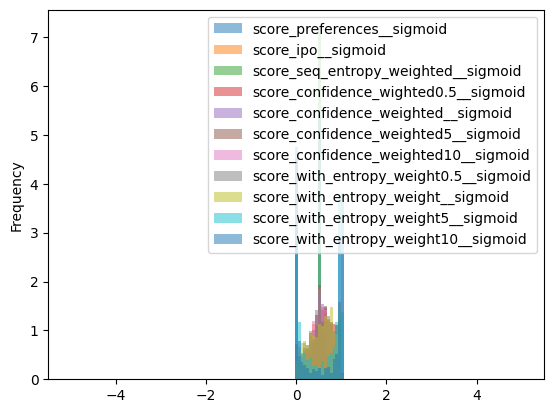

In [35]:
d = df_raw[cols_score].copy()
# d -= d.min()
# d /= d.abs().max()
d.plot.hist(bins=155, range=[-5, 5], alpha=0.5, legend=True, density=True, style="stepped")
d.describe()


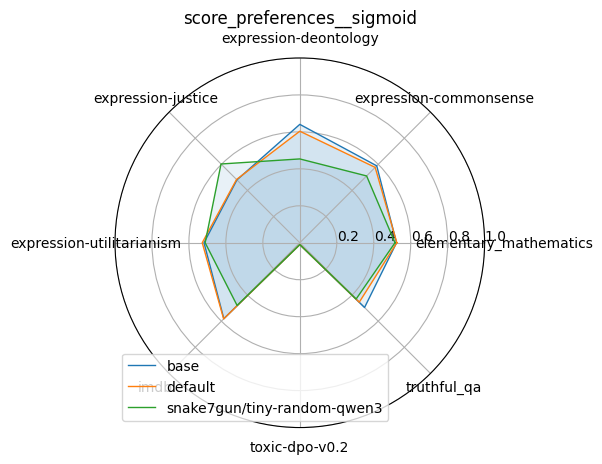

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.523432,0.525055,0.515089
expression-commonsense,0.588689,0.576724,0.511288
expression-deontology,0.640653,0.603630,0.453613
expression-justice,0.481116,0.484158,0.602788
expression-utilitarianism,0.518384,0.528032,0.512214
imdb,0.581309,0.582852,0.479889
toxic-dpo-v0.2,0.010000,0.010000,0.010000
truthful_qa,0.495490,0.454958,0.430854


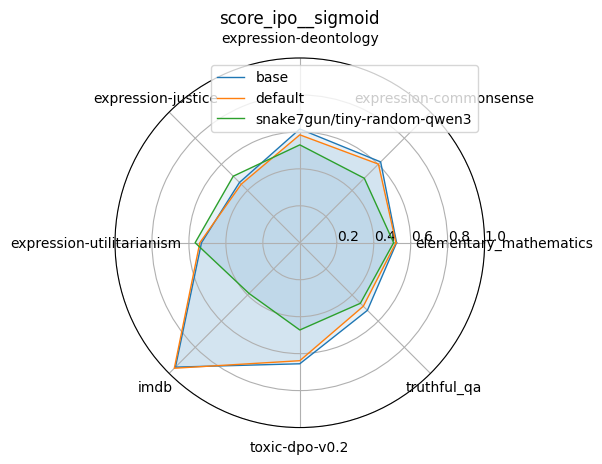

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.523731,0.520374,0.507679
expression-commonsense,0.618647,0.601764,0.493602
expression-deontology,0.615538,0.584019,0.529728
expression-justice,0.461623,0.448348,0.509324
expression-utilitarianism,0.532043,0.541088,0.566437
imdb,0.951714,0.960286,0.388274
toxic-dpo-v0.2,0.654895,0.638293,0.472048
truthful_qa,0.517286,0.485927,0.463373


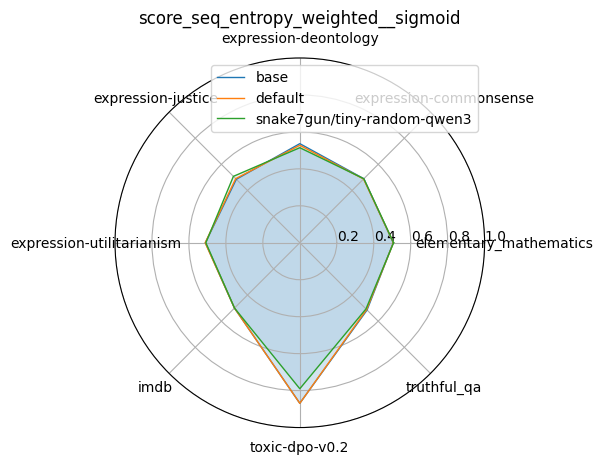

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.505742,0.506523,0.507437
expression-commonsense,0.490063,0.487886,0.489839
expression-deontology,0.536250,0.527568,0.514326
expression-justice,0.485889,0.490630,0.508159
expression-utilitarianism,0.511030,0.512114,0.508408
imdb,0.499961,0.500000,0.499805
toxic-dpo-v0.2,0.868809,0.868799,0.790078
truthful_qa,0.514709,0.511252,0.506411


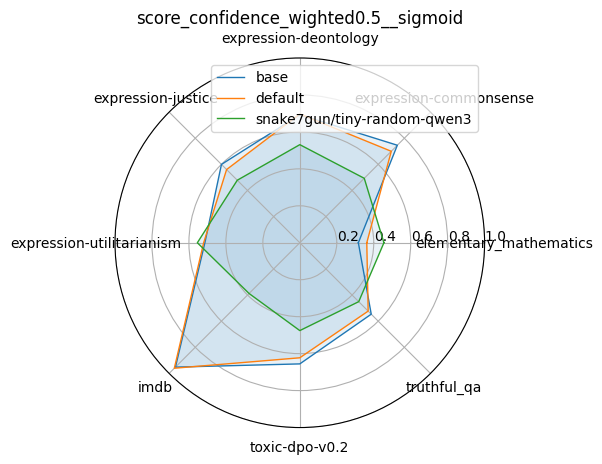

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.316824,0.362451,0.455167
expression-commonsense,0.746242,0.699972,0.493226
expression-deontology,0.692616,0.696842,0.530832
expression-justice,0.599594,0.560261,0.478496
expression-utilitarianism,0.513692,0.520274,0.554426
imdb,0.951714,0.960286,0.388274
toxic-dpo-v0.2,0.655513,0.622489,0.475307
truthful_qa,0.546598,0.523091,0.450812


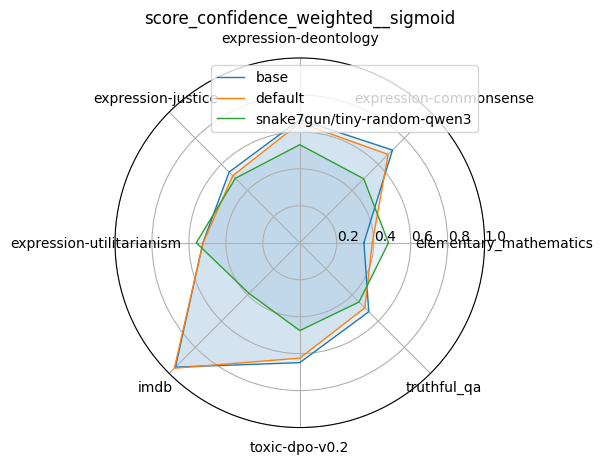

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.347020,0.392550,0.479936
expression-commonsense,0.709260,0.676132,0.489430
expression-deontology,0.666193,0.648736,0.530730
expression-justice,0.541027,0.512947,0.493265
expression-utilitarianism,0.524331,0.523306,0.560319
imdb,0.951714,0.960286,0.388179
toxic-dpo-v0.2,0.648677,0.624302,0.475227
truthful_qa,0.527911,0.497768,0.453456


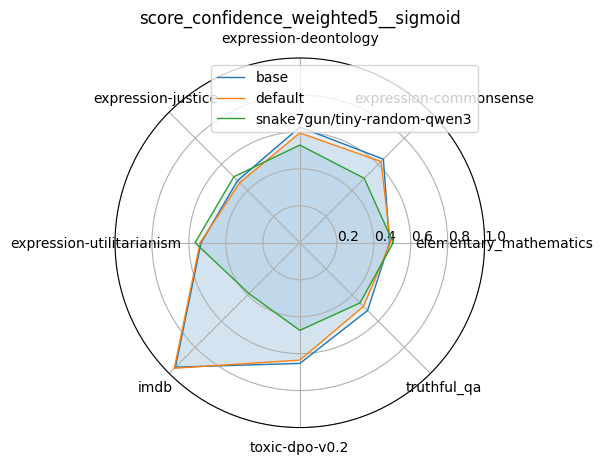

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.485645,0.490367,0.505282
expression-commonsense,0.639595,0.621444,0.493047
expression-deontology,0.625772,0.594218,0.528767
expression-justice,0.476075,0.459535,0.505031
expression-utilitarianism,0.534433,0.539795,0.566956
imdb,0.951931,0.960286,0.389142
toxic-dpo-v0.2,0.653181,0.635065,0.474131
truthful_qa,0.518628,0.487091,0.460622


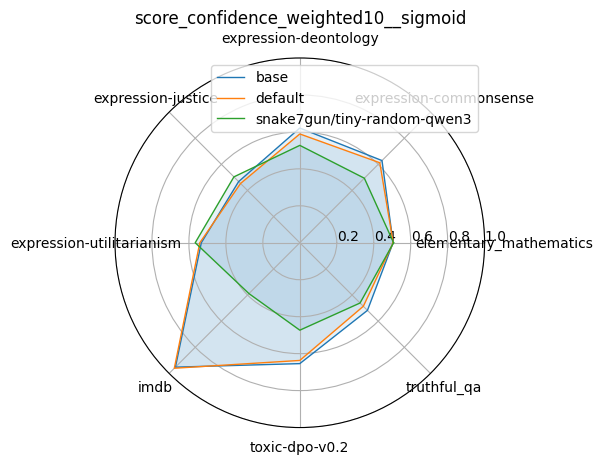

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.504840,0.505459,0.507413
expression-commonsense,0.628975,0.612156,0.493950
expression-deontology,0.620770,0.588758,0.526946
expression-justice,0.468150,0.453575,0.504250
expression-utilitarianism,0.533007,0.541061,0.566006
imdb,0.951931,0.960286,0.389142
toxic-dpo-v0.2,0.654038,0.636818,0.473095
truthful_qa,0.517595,0.486093,0.461060


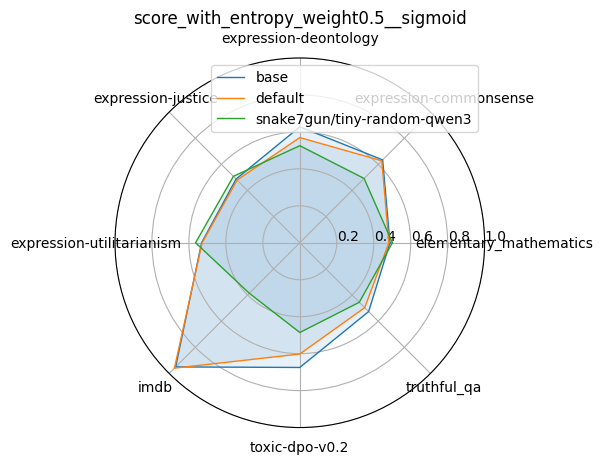

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.487862,0.482138,0.500888
expression-commonsense,0.634065,0.627388,0.492039
expression-deontology,0.627322,0.569162,0.525202
expression-justice,0.487622,0.479854,0.508235
expression-utilitarianism,0.531569,0.528591,0.564209
imdb,0.950087,0.959635,0.386546
toxic-dpo-v0.2,0.674845,0.602160,0.485641
truthful_qa,0.526757,0.496620,0.455466


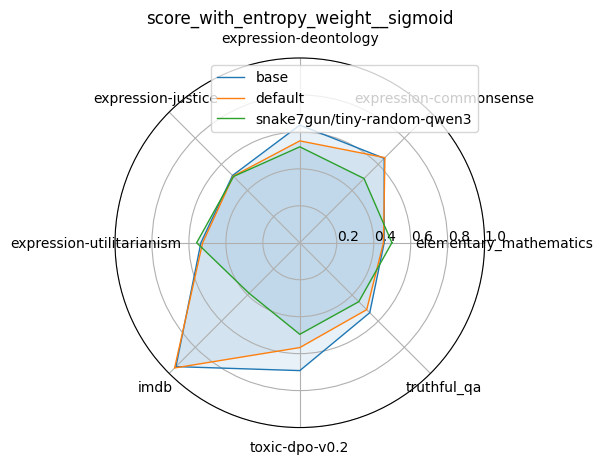

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.456596,0.452863,0.498446
expression-commonsense,0.645943,0.651335,0.491521
expression-deontology,0.636858,0.551362,0.519166
expression-justice,0.514841,0.509706,0.507152
expression-utilitarianism,0.535318,0.525774,0.558209
imdb,0.947917,0.958116,0.387405
toxic-dpo-v0.2,0.691835,0.567283,0.495396
truthful_qa,0.535279,0.511977,0.451174


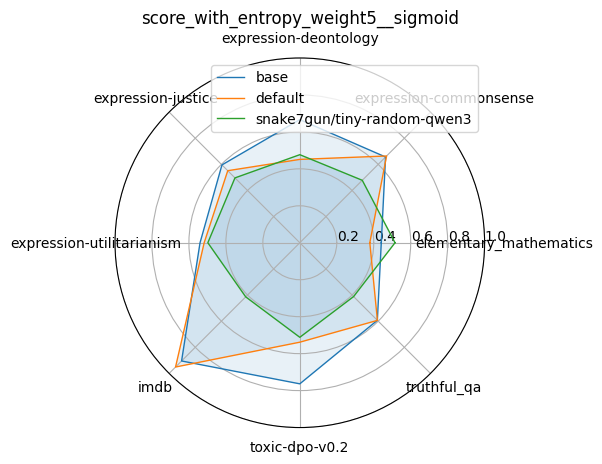

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.440898,0.378776,0.515184
expression-commonsense,0.656231,0.664058,0.477983
expression-deontology,0.666384,0.451066,0.476561
expression-justice,0.595713,0.551420,0.496322
expression-utilitarianism,0.539906,0.517507,0.497698
imdb,0.904731,0.950955,0.414073
toxic-dpo-v0.2,0.763411,0.538066,0.511618
truthful_qa,0.593509,0.593934,0.411808


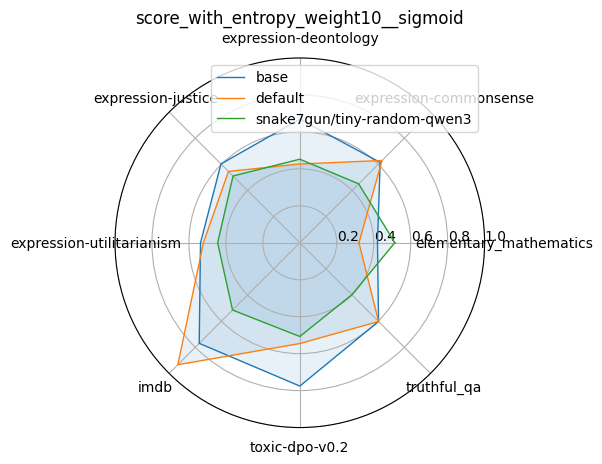

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.420303,0.320062,0.514070
expression-commonsense,0.614824,0.629445,0.450805
expression-deontology,0.669006,0.426055,0.452220
expression-justice,0.603211,0.545863,0.510966
expression-utilitarianism,0.537292,0.521642,0.444584
imdb,0.769748,0.933377,0.514925
toxic-dpo-v0.2,0.775510,0.545354,0.507226
truthful_qa,0.602621,0.602601,0.398212


In [36]:
# what if we apply sigmoid before mean?

df_raw2 = df_raw2a.copy()
# df_raw2[cols_score] = df_raw2[cols_score] > 0.5 # it's in log, so which is prefered
# df_raw2[cols_score] = df_raw2[cols_score].apply(sigmoid)

for c in cols_score:
    df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)[c].mean().unstack()
    radar_plot(df_agg)
    plt.title(c)
    plt.show()
    display(df_agg)
    
    # df_raw2['prob2'] = df_raw2[c] * df_raw2['norm_policy_weights']
    # df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)['prob2'].mean().unstack()
    # # df_agg = df_agg.apply(sigmoid)
    # radar_plot(df_agg)
    # plt.title(c + '_norm')
    # plt.show()

In [37]:
# # what if we apply sigmoid before mean?
# cols_score = [c for c in df_raw.columns if c.startswith('score_')]
# df_raw2 = df_raw.copy()
# # df_raw2[cols_score] = df_raw2[cols_score].apply(sigmoid) # it's in log, so which is prefered

# for c in cols_score:
#     df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)[c].mean().unstack()
#     df_agg = df_agg.apply(sigmoid)
#     radar_plot(df_agg)
#     plt.title(c)
#     plt.show()
    
#     # df_raw2['prob2'] = df_raw2[c] * df_raw2['norm_policy_weights']
#     # df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)['prob2'].mean().unstack()
#     # # df_agg = df_agg.apply(sigmoid)
#     # radar_plot(df_agg)
#     # plt.title(c + '_norm')
#     # plt.show()

In [21]:
# df_agg =  df_raw.groupby(['dataset', 'adapter'], dropna=False)['prob'].mean().unstack()

# radar_plot(df_agg)
# df_agg

In [22]:
# df_raw_bool.pivot(index='adapter', columns='dataset', values=c)
import pandas as pd


In [23]:
# df_agg =  df_raw.groupby(['dataset'], dropna=False)['prob'].mean().to_frame()#.unstack()

# radar_plot(df_agg)
# df_agg

In [29]:
import numpy as np


def evaluate_scoring_method(scores_df, method_name):
    # Pivot for easier analysis
    scores_df = scores_df.copy()
    mins = scores_df[method_name].min()
    maxs = scores_df[method_name].max()
    scores_df[method_name] = scores_df[method_name].replace([np.inf, -np.inf], np.nan)
    scores = pd.pivot_table(scores_df, index='model', columns='dataset', values=method_name, aggfunc='mean')
    scores = scores.clip(lower=0, upper=1)  # Clip scores to [0, 1] range
    # print(scores)
    
    # 1. IMDB should be high (most models > 0.8)
    imdb_score = scores['imdb'].drop(index='snake7gun/tiny-random-qwen3').mean()
    
    # 2. Hard datasets should be low (if you have a hard_math dataset)
    hard_math_score = scores['elementary_mathematics'].mean()# if 'elementary_mathematics' in scores else 0.5
    hard_math_penalty = 1 - abs(hard_math_score - 0.5)

    # 3. Random model should be ~0.5
    random_model = 'snake7gun/tiny-random-qwen3'  # your random model
    random_deviation = abs(scores.loc[random_model].mean() - 0.5)
    random_penalty = 1 - random_deviation  # 1 is good, 0 is bad
    
    # FIXME we want a bit of contrast in all datasets, not a lot in one
    # 4. High contrast between models (especially toxic, math)
    contrast_datasets = ['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology' ]
    contrasts = [scores[ds].std() / scores[ds].mean().clip(0.001) for ds in contrast_datasets if ds in scores]
    avg_contrast = np.prod(contrasts) ** (1/len(contrasts)) if contrasts else 0



    # avg_contrast = scores.std() / scores.mean() if not scores.empty else 0
    
    # 5. censored vs uncensored should differ on toxic
    if 'toxic-dpo-v0.2' in scores:
        # Assuming censored models score low, uncensored high
        toxic_spread = scores['toxic-dpo-v0.2'].max() - scores['toxic-dpo-v0.2'].min()
    else:
        toxic_spread = 0
    
    # Combined score
    quality = (
        imdb_score * 2 +              # weight easy dataset performance
        random_penalty * 3 +          # important: random = 0.5
        avg_contrast * 2 +            # discrimination power
        toxic_spread +                 # specific contrast we expect
        hard_math_penalty               # weight hard dataset performance
    ) / 10  # normalize to [0, 1]

    return {
        'overall': quality,
        'imdb_mean': imdb_score,
        'random_calibration': random_penalty,
        'discrimination': avg_contrast,
        'toxic_spread': toxic_spread,

        'hard_math': hard_math_score,
        'min': mins,
        'max': maxs,

    }


# cols = [c for c in df2.columns if 'score' in c]
# res = {}
# for c in cols:
#     v = evaluate_scoring_method(df2, c)
#     res[c] = v

#     # df2['correct2'] = df2[c]>0.5
#     # v = evaluate_scoring_method(df2, 'correct2')
#     # res[f'{c}_bool'] = v


# res = pd.DataFrame(res).T.sort_values('overall', ascending=False)
# res

In [30]:
df_raw[cols_score].describe()

,score_preferences__sigmoid,score_preferences__logratio,score_preferences__correct,score_ipo__sigmoid,score_ipo__logratio,score_ipo__correct,score_seq_entropy_weighted__sigmoid,score_seq_entropy_weighted__logratio,score_seq_entropy_weighted__correct,score_confidence_wighted0.5__sigmoid,...,score_with_entropy_weight__sigmoid,score_with_entropy_weight__logratio,score_with_entropy_weight__correct,score_with_entropy_weight5__sigmoid,score_with_entropy_weight5__logratio,score_with_entropy_weight5__correct,score_with_entropy_weight10__sigmoid,score_with_entropy_weight10__logratio,score_with_entropy_weight10__correct,score_weighted
count,2400.000000,2400.000000,2400.000000,1434.000000,1434.000000,2400.000000,2400.000000,2400.000000,2400.000000,1434.000000,...,1434.000000,1434.000000,2400.000000,1.434000e+03,1434.000000,2400.000000,1.434000e+03,1434.000000,2400.000000,1434.000000
mean,0.463342,-139.562027,0.270000,0.552345,0.308033,0.349583,0.547570,0.258185,0.382500,0.576152,...,0.556181,0.347232,0.355417,5.582721e-01,0.501351,0.337083,5.495978e-01,0.698549,0.325833,0.307706
std,0.371623,639.049744,0.444052,0.246423,1.677992,0.476938,0.179188,0.960460,0.486099,0.281575,...,0.279062,1.868666,0.478739,4.109060e-01,4.859535,0.472812,4.528434e-01,9.376685,0.468783,1.675245
min,0.000000,-5824.000000,0.000000,0.000179,-8.625000,0.000000,0.031738,-3.421875,0.000000,0.000012,...,0.000191,-8.562500,0.000000,7.188646e-09,-18.750000,0.000000,2.439455e-17,-38.250000,0.000000,-8.750000
25%,0.001066,-6.843750,0.000000,0.392578,-0.437500,0.000000,0.500000,-0.001127,0.000000,0.389160,...,0.332520,-0.699219,0.000000,7.568359e-02,-2.500000,0.000000,6.683350e-03,-5.000000,0.000000,-0.437500
50%,0.500000,0.000000,0.000000,0.562500,0.250000,0.000000,0.500000,0.000000,0.000000,0.605469,...,0.585938,0.343750,0.000000,7.070312e-01,0.875000,0.000000,7.890625e-01,1.312500,0.000000,0.250000
75%,0.798828,1.384766,1.000000,0.729492,0.987305,1.000000,0.613281,0.460938,1.000000,0.808594,...,0.781250,1.265625,1.000000,9.687500e-01,3.406250,1.000000,9.960938e-01,6.093750,1.000000,1.000000
max,1.000000,832.000000,1.000000,1.000000,10.625000,1.000000,0.988281,4.375000,1.000000,1.000000,...,1.000000,10.125000,1.000000,1.000000e+00,30.000000,1.000000,1.000000e+00,59.500000,1.000000,10.500000


In [31]:
# scores = pd.pivot_table(df_raw, index='adapter', columns='dataset', values=cols_score, aggfunc='mean')
# scores.describe()

In [32]:

df_raw_bool = df_raw.copy()
cols_score = [c for c in df_raw_bool.columns if c.startswith('score_')]#+['correct']
df_raw_bool[cols_score] = df_raw_bool[cols_score] > 0.5 # it's in log, so which is prefered
df_raw_bool['dataset'] = df_raw_bool['dataset'].apply(rename_ds)

df_raw2 = df_raw.copy()
# df_raw2[cols_score] = df_raw2[cols_score] > 0.5 # it's in log, so which is prefered
df_raw2['dataset'] = df_raw2['dataset'].apply(rename_ds)    


res = {}
for c in cols_score:
    v2 = evaluate_scoring_method(df_raw2, c)
    print(f"{v2['overall']:.2f} {c}")
    res[c] = v2



0.50 score_preferences__sigmoid
0.53 score_preferences__logratio
0.31 score_preferences__correct
0.62 score_ipo__sigmoid
0.51 score_ipo__logratio
0.43 score_ipo__correct
0.50 score_seq_entropy_weighted__sigmoid
0.25 score_seq_entropy_weighted__logratio
0.34 score_seq_entropy_weighted__correct
0.63 score_confidence_wighted0.5__sigmoid
0.49 score_confidence_wighted0.5__logratio
0.41 score_confidence_wighted0.5__correct
0.62 score_confidence_weighted__sigmoid
0.49 score_confidence_weighted__logratio
0.37 score_confidence_weighted__correct
0.62 score_confidence_weighted5__sigmoid
0.50 score_confidence_weighted5__logratio
0.41 score_confidence_weighted5__correct
0.62 score_confidence_weighted10__sigmoid
0.50 score_confidence_weighted10__logratio
0.41 score_confidence_weighted10__correct
0.62 score_with_entropy_weight0.5__sigmoid
0.50 score_with_entropy_weight0.5__logratio
0.39 score_with_entropy_weight0.5__correct
0.62 score_with_entropy_weight__sigmoid
0.73 score_with_entropy_weight__logra

In [33]:
res2 = pd.DataFrame(res).T.sort_values('discrimination', ascending=False)
res2

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,hard_math,min,max
score_with_entropy_weight__logratio,0.734810,1.000000,0.607484,1.205880,5.971979e-01,0.016690,-8.562500e+00,10.125000
score_ipo__correct,0.425494,0.175000,0.777500,0.222470,5.250000e-01,0.102500,0.000000e+00,1.000000
score_with_entropy_weight10__correct,0.383797,0.160000,0.768750,0.219613,1.800000e-01,0.092500,0.000000e+00,1.000000
score_confidence_wighted0.5__correct,0.412947,0.175000,0.771250,0.217862,4.550000e-01,0.075000,0.000000e+00,1.000000
score_with_entropy_weight5__correct,0.389680,0.180000,0.776250,0.204027,1.950000e-01,0.105000,0.000000e+00,1.000000
score_confidence_weighted5__correct,0.414098,0.175000,0.772500,0.187990,5.050000e-01,0.092500,0.000000e+00,1.000000
score_with_entropy_weight10__sigmoid,0.608958,0.851562,0.974126,0.184373,1.532066e-01,0.442126,2.439455e-17,1.000000
score_confidence_wighted0.5__sigmoid,0.626551,0.956000,0.978317,0.178729,1.636938e-01,0.397402,1.221895e-05,1.000000
score_with_entropy_weight5__sigmoid,0.620175,0.927843,0.975156,0.159484,1.391203e-01,0.462511,7.188646e-09,1.000000
score_confidence_weighted10__correct,0.411326,0.175000,0.777500,0.159132,5.100000e-01,0.102500,0.000000e+00,1.000000
